In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import curve_fit
from scipy.integrate import odeint

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#121212'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
rc('font',**{'family':'serif','serif':['New Century Schoolbook']})

# For the rolling average
window_size = 7

In [2]:
######################################################
# The four ODEs being considered

def ODE_BSM(x, t, beta, k, a):
    return beta*x*(1 - x/k + a*x*x)

def ODE_GRM(x, t, beta, k, p, a):
    return beta*x**p*(1 - (x/k)**a)

def ODE_GLM(x, t, beta, k, p):
    return ODE_GRM(x, t, beta, k, p, 1)

def ODE_LM(x, t, beta, k):
    return ODE_GRM(x, t, beta, k, 1, 1)

######################################################
# Functions to solve ODEs

def ODE_BSM_sol(t, x0, beta, k, a):
    x = odeint(ODE_BSM, x0, t, args=(beta, k, a))
    return x.reshape(1,-1)[0]

def ODE_GRM_sol(t, x0, beta, k, p, a):
    x = odeint(ODE_GRM, x0, t, args=(beta, k, p, a))
    return x.reshape(1,-1)[0]

def ODE_GLM_sol(t, x0, beta, k, p):
    x = odeint(ODE_GLM, x0, t, args=(beta, k, p))
    return x.reshape(1,-1)[0]

def ODE_LM_sol(t, x0, beta, k):
    x = odeint(ODE_LM, x0, t, args=(beta, k))
    return x.reshape(1,-1)[0]

######################################################
# Functions to get the gradient of the solved ODEs

def ODE_BSM_grad(t, x0, beta, k, a):
    x = odeint(ODE_BSM, x0, t, args=(beta, k, a))
    return ODE_BSM(x.reshape(1,-1)[0], t, beta, k, a)

def ODE_GRM_grad(t, x0, beta, k, p, a):
    x = odeint(ODE_GRM, x0, t, args=(beta, k, p, a))
    return ODE_GRM(x.reshape(1,-1)[0], t, beta, k, p, a)

def ODE_GLM_grad(t, x0, beta, k, p):
    x = odeint(ODE_GLM, x0, t, args=(beta, k, p))
    return ODE_GLM(x.reshape(1,-1)[0], t, beta, k, p)

def ODE_LM_grad(t, x0, beta, k):
    x = odeint(ODE_LM, x0, t, args=(beta, k))
    return ODE_LM(x.reshape(1,-1)[0], t, beta, k)

######################################################

def fitODE_grad(df, p0, model, bounds=0):
    df = df.sort_values(by=['X'])
    x_g = df['X'].values
    y_g = df['Y'].values
    if model == 'BSM':
        fit, covar = curve_fit(ODE_BSM_grad, x_g, y_g, p0=p0)
    elif model == 'GRM':
        fit, covar = curve_fit(ODE_GRM_grad, x_g, y_g, p0=p0, bounds=((bounds, 0., 0., 0., 0.), (0.1, 6, 1., 1., 2.)))
    elif model == 'GLM':
        fit, covar = curve_fit(ODE_GLM_grad, x_g, y_g, p0=p0, bounds=(bounds, [0.1, 10., 1., 2]))
    elif model == 'LM':
        fit, covar = curve_fit(ODE_LM_grad, x_g, y_g, p0=p0)
    return fit, covar

######################################################


def makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact=1./2., label=True, alpha=1):
    df_p = pd.DataFrame()
    if len(country) != len(startdate):
        print('unequal input lists')
        exit(1)
    for i in range(len(country)):
        df = ((df_c[df_c['Country/Region']==country[i]].iloc[-1:]).iloc[0][4:]).rolling(window_size).mean().dropna()
        df.index = pd.to_datetime(df.index)
        df = df[startdate[i]:]
        Nmax = df[datet_max[i]]
        t1_2 = (df.iloc[(df-Nmax*fact).abs().argsort()[:1]].index[0]-datetime.datetime.strptime(startdate[i], '%Y-%m-%d')).days
        x = np.linspace(1,len(df[:datet_max[i]]),len(df[:datet_max[i]]))/t1_2
        df_r = df[:datet_max[i]]/Nmax
        df_temp = pd.DataFrame()
        df_temp['X'] = x
        df_temp['Y'] = df_r.values
        df_temp['country'] = country[i]
        df_temp['Nmax'] = Nmax
        df_temp['t1/2'] = t1_2
        df_p = pd.concat([df_p, df_temp])
        if label: plt.scatter(df_temp.X, df_temp.Y, label=country[i]+r' [$N_{\rm max}: $ ' + str(int(round(Nmax))) + ']', marker=markers[i], s=20, alpha=0.3)
        else: plt.scatter(df_temp.X, df_temp.Y, marker=markers[i], s=20, alpha=alpha)
    return plt, df_p

def analyze(df_c, country, startdate, datet_max, markers, plt, fact=1./2., allmodels=False):
    
    plt.subplot(1,2,1)
    plt, df_p = makeuniversal(df_c, country, startdate, datet_max, markers, plt, fact)
    leg = plt.legend(fontsize=12, loc='lower right', handletextpad=0)
    if allmodels: leg = plt.legend(fontsize=11, loc='upper left', handletextpad=0)
    ax = plt.gca()

    fit_array = []
    covar_array = []
    x_p = np.linspace(0, np.max(df_p['X'].values), 1000)
            
    ax.add_artist(leg)
    plt.xlim((0,2.5))
    plt.grid()
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    plt.xlabel(r'$\tilde t$',fontsize=18)
    plt.ylabel(r'$\tilde N(\tilde t)$',fontsize=18)
    
    x0_d = 0
    for cc in df_p.country.unique():
        x0_d += df_p[df_p['country']==cc].Y.iloc[0]
    x0_d = x0_d/len(df_p.country.unique())
    
    
    plt.subplot(1,2,2)
    df_g = pd.DataFrame()
    for i in range(len(country)):
        df_pp = pd.DataFrame()
        df_pp = df_p[df_p['country']==country[i]][['X']]
        df_pp['diff'] = df_p[df_p['country']==country[i]][['X']].diff()
        df_pp['Y'] = df_p[df_p['country']==country[i]][['Y']].diff()#.rolling(window_size).mean()
        df_pp.dropna(inplace=True)
        df_pp['Y'] = df_pp['Y']/df_pp['diff']
        df_pp['country'] = country[i]
        df_g = pd.concat([df_g, df_pp[['X', 'Y', 'country']]])
        plt.scatter(df_pp['X'], df_pp['Y'], label=country[i]+ r' [$t_{1/2}: $ ' + str(df_p[df_p['country']==country[i]][['t1/2']].values[0][0]) + ' days]', marker=markers[i], s=20, alpha=0.3)
    plt.xlim((0, 2.5))
    plt.xlabel(r'$\tilde t$', fontsize=18)
    plt.ylabel(r'$d\tilde N(\tilde t)/d\tilde t$', fontsize=18)
    ax = plt.gca()
    leg = plt.legend(fontsize=11, loc='upper right', handletextpad=0)
    
    if allmodels:
        fit, covar = fitODE_grad(df_g, p0=[0.001, 5, 0.9, 0.25], model='BSM')
        fit_array.append(fit)
        covar_array.append(covar)
        plt.plot(x_p, ODE_BSM_grad(x_p, fit[0], fit[1], fit[2], fit[3]), color='#71c5e7', linewidth=3,
                 label=r'Blue Sky model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+r', $\alpha$: '+str(round(fit[3],2))+')')
        
        fit, covar = fitODE_grad(df_g, p0=[0.001, 5, 1], model='LM')
        fit_array.append(fit)
        covar_array.append(covar)
        plt.plot(x_p, ODE_LM_grad(x_p, fit[0], fit[1], fit[2]), color='#434343', linewidth=3,
                 label=r'logistic growth model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+')')

        fit, covar = fitODE_grad(df_g, p0=[0.05, 5, 1, 1], model='GLM', bounds=x0_d)
        fit_array.append(fit)
        covar_array.append(covar)
        plt.plot(x_p, ODE_GLM_grad(x_p, fit[0], fit[1], fit[2], fit[3]), color='#c0142f', linewidth=3,
                 label=r'generalized logistic model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+r', $\pi$: '+str(round(fit[3],2))+')')

        fit, covar = fitODE_grad(df_g, p0=[0.05, 3.6, 0.91, 0.73, 1.4], model='GRM', bounds=x0_d)
        fit_array.append(fit)
        covar_array.append(covar)
        plt.plot(x_p, ODE_GRM_grad(x_p, fit[0], fit[1], fit[2], fit[3], fit[4]), color='#4b659a', linewidth=3,
                 label=r'generalized Richards model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+r', $\pi$: '+str(round(fit[3],2))+r', $\alpha$: '+str(round(fit[4],2))+')')

    ax.add_artist(leg)
    plt.grid()
    plt.tick_params(axis="x", labelsize=16)
    plt.tick_params(axis="y", labelsize=16)
    
    plt.subplot(1,2,1)
    
    if allmodels:
        fit = fit_array[0]
        plt.plot(x_p, ODE_BSM_sol(x_p, fit[0], fit[1], fit[2], fit[3]), color='#71c5e7', linewidth=3,
                 label=r'Blue Sky model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+r', $\alpha$: '+str(round(fit[3],2))+')')
        
        fit = fit_array[1]
        plt.plot(x_p, ODE_LM_sol(x_p, fit[0], fit[1], fit[2]), color='#434343', linewidth=3,
                 label=r'logistic growth model' + '\n' + r'($x_0$:'+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+')')

        fit = fit_array[2]
        plt.plot(x_p, ODE_GLM_sol(x_p, fit[0], fit[1], fit[2], fit[3]), color='#c0142f', linewidth=3,
                 label=r'generalized logistic model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+r', $\pi$: '+str(round(fit[3],2))+')')
        
        fit = fit_array[3]
        plt.plot(x_p, ODE_GRM_sol(x_p, fit[0], fit[1], fit[2], fit[3], fit[4]), color='#4b659a', linewidth=3,
                 label=r'generalized Richards model' + '\n' + r'($x_0$: '+str(round(fit[0],4))+r', $\beta$: '+str(round(fit[1],2))+r', $\kappa$: '+str(round(fit[2],2))+r', $\pi$: '+str(round(fit[3],2))+r', $\alpha$: '+str(round(fit[4],2))+')')

    
    if allmodels:
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[:4]
        labels = labels[:4]
        plt.legend(handles=handles, labels=labels, fontsize=11, loc= 'lower right')
    
    
    return plt, fit_array, covar_array

In [3]:
# Pull in the data processed in DataScout-UniversalityClasses.ipynb
countries = pd.read_csv('data/countries.csv')

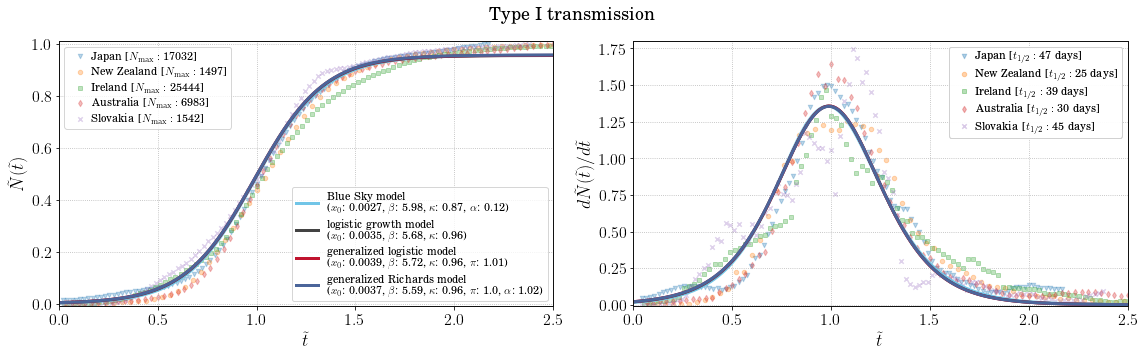

In [6]:
country = ['Japan', 'New Zealand', 'Ireland', 'Australia', 'Slovakia']
startdate = ['2020-3-1', '2020-3-10', '2020-3-10', '2020-3-1', '2020-3-1']
datet_max = ['2020-6-10', '2020-5-15', '2020-7-1', '2020-5-15', '2020-6-15']
markers = ['v', 'o', 's', 'd', 'x']

fig = plt.figure(figsize=(16,5))
plt, fit_1, covar_1 = analyze(countries, country, startdate, datet_max, markers, plt, allmodels=True)

ax = fig.axes
ax[1].set_ylim([-0.01,1.8])
ax[0].set_ylim([-0.01,1.01])
# ax[2].set_ylim([-0.01,1.8])
plt.suptitle('Type I transmission', fontsize=18)
plt.tight_layout()
plt.savefig('../plots/universal_1_allmodels.pdf', facecolor='white', dpi=300)
plt.show()

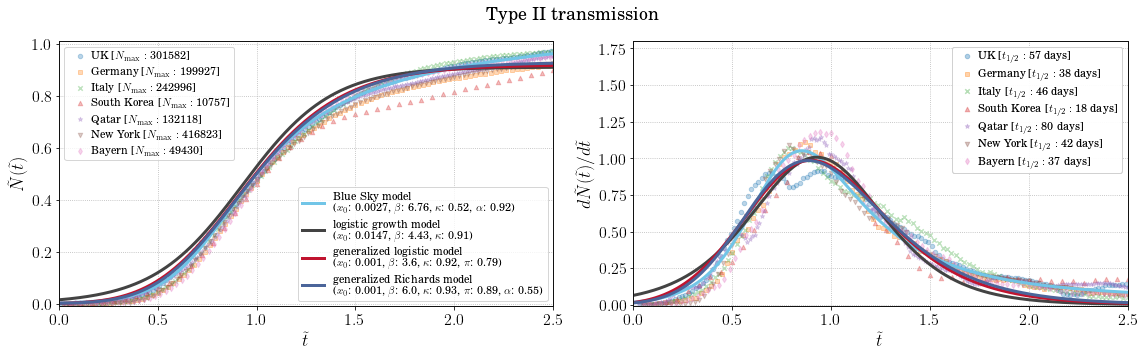

In [5]:
country = ['UK', 'Germany', 'Italy', 'South Korea', 'Qatar', 'New York', 'Bayern']
startdate = ['2020-3-1','2020-3-1', '2020-2-20', '2020-2-18', '2020-3-20', '2020-3-5', '2020-3-1']
datet_max = ['2020-8-1', '2020-7-15', '2020-7-15', '2020-5-1', '2020-11-1', '2020-8-1', '2020-7-15']
markers = ['o', 's', 'x', '^', '*', 'v', 'd']

fig = plt.figure(figsize=(16,5))
plt, fit_2, covar_2 = analyze(countries, country, startdate, datet_max, markers, plt, allmodels=True)

ax = fig.axes
ax[1].set_ylim([-0.01,1.8])
ax[0].set_ylim([-0.01,1.01])
plt.suptitle('Type II transmission', fontsize=18)
plt.tight_layout()
plt.savefig('../plots/universal_2_allmodels.pdf', facecolor='white', dpi=300)
plt.show()